In [1]:
#Import required libraries
import cv2
import numpy as np
import math
import os
import numpy as np
import random
import matplotlib.pyplot as plt

In [2]:
#Calculate the area of a hand
def calculate_hand_area(image):
    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Apply Gaussian blur to the image
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    # Apply thresholding to the image
    _, threshold = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)

    # Find contours in the thresholded image
    contours, _ = cv2.findContours(threshold, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # Select the contour with maximum area, this should be the hand contour
    hand_contour = max(contours, key=cv2.contourArea)

    # Return the area of the hand contour
    return cv2.contourArea(hand_contour)

In [3]:
#Calculate average area of images in directory
def calculate_average_area(directory):
    hand_areas = []
    # Loop over all .png images in the specified directory
    for filename in os.listdir(directory):
        if filename.endswith('.png'):  
            image = cv2.imread(os.path.join(directory, filename))
            if image is not None:
                # Calculate the hand area for the current image
                hand_area = calculate_hand_area(image)
                hand_areas.append(hand_area)
    # Calculate the average hand area
    average_hand_area = sum(hand_areas) / len(hand_areas)
    return average_hand_area

In [4]:
#Calculate threshold area
def calculate_threshold(closed_hand_directory, one_finger_directory):
    # Calculate the average hand area for images of a closed hand
    average_closed_hand_area = calculate_average_area(closed_hand_directory)
    # Calculate the average hand area for images of a hand with one finger raised
    average_one_finger_area = calculate_average_area(one_finger_directory)

    # The threshold is the average of these two average areas
    thresh = (average_closed_hand_area + average_one_finger_area) / 2

    return thresh

In [5]:

# load all image file paths from the specified parent directory and its subdirectories, 
# then randomly shuffle the paths
def load_and_shuffle_images(parent_directory):
    image_files = []  # Initialize a list to store the image file paths

    # Iterate through each subdirectory (from 0 to 5) in the parent directory
    for i in range(6):
        # Create the full path to the current subdirectory
        folder_path = os.path.join(parent_directory, str(i))

        # Iterate through each file in the current subdirectory
        for filename in os.listdir(folder_path):
            # If the file is an image (.png), add its path to the image_files list
            if filename.endswith('.png'):  
                image_file_path = os.path.join(folder_path, filename)
                image_files.append(image_file_path)
    
    # Randomly shuffle the list of image file paths
    random.shuffle(image_files)

    # Return the shuffled list of image file paths
    return image_files


In [6]:
#Get angle betweeen fingers
def calculate_angle(start, farthest, end):
    #Calculate the angle between three points using the cosine rule
    a = math.sqrt((end[0] - farthest[0])**2 + (end[1] - farthest[1])**2)
    b = math.sqrt((start[0] - farthest[0])**2 + (start[1] - farthest[1])**2)
    c = math.sqrt((start[0] - end[0])**2 + (start[1] - end[1])**2)
    angle = math.acos((a**2 + b**2 - c**2) / (2*a*b))
    
    return math.degrees(angle)

In [7]:
#Apply preprocessing to the image
def preprocess_image(image_path):

    # Load the image from the specified file path
    image = cv2.imread(image_path)
    
    # Convert the color image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Apply a Gaussian blur to the grayscale image, using a kernel size of 5x5 pixels and a sigma of 0
    # This helps to reduce noise and detail in the image
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    
    # Apply Otsu's binarization method to the blurred image
    # This method automatically determines an optimal threshold value to separate the image into binary classes (black and white)
    _, threshold = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    # Return both the original image and the preprocessed (thresholded) image
    return image, threshold


In [8]:
#Get Hand Countour
def get_hand_contour(threshold_image):
    #Identify the hand contour in a thresholded image
    contours, _ = cv2.findContours(threshold_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # Select the contour with maximum area, this should be the hand contour
    hand_contour = max(contours, key=cv2.contourArea)
    
    return hand_contour

In [9]:
#Count the number of fingers
def count_fingers(hand_contour,hand_area, thresh):
    """Count the number of fingers shown in the hand contour"""
    # Calculate the convex hull of the hand contour
    hull = cv2.convexHull(hand_contour, returnPoints=False)
    # Calculate the convexity defects of the hand contour
    defects = cv2.convexityDefects(hand_contour, hull)

    fingers = 0
    
    # If the hand area is greater than the threshold, a finger is considered raised
    if hand_area > thresh:
        fingers = 1
        if defects is not None:
            # Loop over the defects
            for i in range(defects.shape[0]):
                # Get the start, end and farthest point of the defect
                start, end, _, _ = defects[i, 0]
                start_point = tuple(hand_contour[start][0])
                end_point = tuple(hand_contour[end][0])
                farthest_point = tuple(hand_contour[defects[i, 0][2]][0])

                # Calculate the depth and angle of the defect
                depth = defects[i, 0][3] / 256
                angle = calculate_angle(start_point, farthest_point, end_point)

                # If the depth is greater than 15 and the angle is less than 90, count the defect as a raised finger
                if depth > 15 and angle < 90:
                    fingers += 1
                    
    return fingers


In [10]:
# Evaluate the accuracy of finger count prediction
def evaluate_accuracy(directory, expected_fingers):
    correct_predictions = 0  # Initialize counter for correct finger count predictions
    total_images = 0  # Initialize counter for total images processed

    # Iterate through all files in the specified directory
    for filename in os.listdir(directory):
        # If the file is an image (.png), process it
        if filename.endswith('.png'):  
            # Create the full file path by joining the directory and filename
            image_path = os.path.join(directory, filename)

            # Preprocess the image and obtain the thresholded image
            image, threshold_image = preprocess_image(image_path)

            # Identify the hand contour in the thresholded image
            hand_contour = get_hand_contour(threshold_image)

            # Calculate the hand area in the image
            hand_area = calculate_hand_area(image) 

            # Predict the number of fingers in the image
            predicted_fingers = count_fingers(hand_contour, hand_area, thresh)

            # If the predicted finger count matches the expected finger count, increment correct_predictions
            if predicted_fingers == expected_fingers:
                correct_predictions += 1

            # Increment total_images counter
            total_images += 1

    # Calculate the accuracy as the ratio of correct predictions to total images processed
    accuracy = correct_predictions / total_images
    return accuracy



Enter index of image to process between 0-299:7
Hand Area: 1434.5
Palm_Area 1371.31
Number of fingers raised:  1


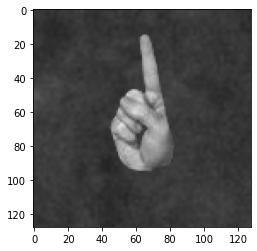

In [11]:
#Run this cell to choose image to process, Enter index between 0-299

# Define the directories where images of a closed hand (0 fingers raised) and one finger raised are stored
closed_hand_directory = './fingers/0'
one_finger_directory = './fingers/1'

# Call the calculate_threshold function to calculate the threshold area to differentiate between 0 and 1 finger raised.
# This function calculates the average area of hands in the images in the closed_hand_directory and one_finger_directory,
# and then sets the threshold as the midpoint of these two average areas.
thresh = calculate_threshold(closed_hand_directory, one_finger_directory)

# Define the path of the image for which the number of raised fingers has to be identified
image_path = "./fingers/"
shuffled_images = load_and_shuffle_images(image_path)

# Call the preprocess_image function to load and preprocess the image. This function returns the original image and 
# the preprocessed (grayscale, blurred and thresholded) image
#Select an Image to process from a list of all the images contained in shuffled_images
index = int(input("Enter index of image to process between 0-299:"))
image, threshold_image = preprocess_image(shuffled_images[index])

# Call the get_hand_contour function to identify the contour of the hand in the thresholded image
hand_contour = get_hand_contour(threshold_image)

# Calculate the area of the hand in the image
hand_area=calculate_hand_area(image)

# Call the count_fingers function to count the number of fingers shown in the hand contour. This function uses the 
# calculated threshold and the area of the hand in the image to differentiate between a closed fist and a hand with 
# one finger raised. It then counts the number of convexity defects in the hand contour to identify additional fingers.
fingers = count_fingers(hand_contour,hand_area, thresh)

# Print the Image, calculated area of the hand in the image, the calculated threshold, and the identified number of fingers
plt.imshow(image)
print("Hand Area:", hand_area)
print("Palm_Area", thresh)
print("Number of fingers raised: ",fingers)


In [13]:
# Run this code to print accuracy results

root_directory = './fingers'  # Directory containing the finger count images
accuracies = []  # List to store the accuracy for each finger count (0 to 5)

# Iterate through each finger count (0 to 5)
for i in range(6):
    # Create the directory path for the current finger count
    directory = os.path.join(root_directory, str(i))
    
    # Evaluate the accuracy of prediction for the current finger count
    accuracy = evaluate_accuracy(directory, i)
    
    # Append the accuracy to the accuracies list
    accuracies.append(accuracy)
    
    # Print the accuracy for the current finger count
    print(f"Accuracy for {i} fingers: {accuracy*100:.2f}%")

# Calculate and print the average accuracy across all finger counts
average_accuracy = sum(accuracies) / len(accuracies)
print(f"Average accuracy: {average_accuracy*100:.2f}%")


Accuracy for 0 fingers: 78.00%
Accuracy for 1 fingers: 70.00%
Accuracy for 2 fingers: 78.00%
Accuracy for 3 fingers: 96.00%
Accuracy for 4 fingers: 100.00%
Accuracy for 5 fingers: 76.00%
Average accuracy: 83.00%
